# 7 · KMCCA & Controlled RSA ― Overview  

This notebook combines two multivariate analyses to dissect the visual system’s representational geometry.  
1. **KMCCA** aligns response matrices across subjects, revealing low‑dimensional stimulus structure shared within a hub.  
2. **Controlled RSA** (partial RSA) quantifies how much *independent* variance each semantic / perceptual factor explains in brain ↔ brain or brain ↔ model alignment.  
We first import helper functions, define file paths, then walk from exploratory projections to formal statistical contrasts.


## 1 – Imports  

Load core scientific Python stack plus custom utilities from the _convergence_ toolkit.  
* `scatter_plots` = tidy wrapper for seaborn joint scatter + marginal histograms.  
* `unify_controlled_rsa_data` = merges partial‑RSA outputs across modalities into a long table (tidy format).  



In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
from convergence.figures import setup_matplotlib_fonts, scatter_plots
from convergence.plotting import plot_faverage_parcelation
# To make this notebook more readable, we have moved some functions for 
# ploting and aggregating data that are reused in different parts of this notebook to
from convergence.figures_controlled_rsa import (
    obtain_modality_main_controls,
    plot_clusters_controled,
    unify_controlled_rsa_data,
    apa_star,
)

setup_matplotlib_fonts()


## 2 – Define data paths  
All inputs live under `../derivatives`.  

* **KMCCA** projections (`kmcca_projections.parquet`)  
* **Controlled RSA** tables (subject‑subject & subject‑model; joined & separated hemispheres)  
* **Top‑word loadings** from the KMCCA subspace (used later for interpretability)  

The output folder `../figures/07_kmcca_projections` is created here.


In [2]:
data_folder = Path("../derivatives")
nsd_derivatives = data_folder / "nsd"
filename_projections = nsd_derivatives / "kmcca_projections.parquet"
filename_objects = nsd_derivatives / "nsd_scenes_objects.parquet"
filename_hcp = data_folder / "metadata" / "hcp.csv"
filename_model_controled_joined = nsd_derivatives / "rsa_subject_model_alignment_controled_joined.parquet"
filename_model_controled_separated = nsd_derivatives / "rsa_subject_model_alignment_controled_separated.parquet"
filename_intersubject_controled_joined = nsd_derivatives / "rsa_subject_subject_alignment_controled_joined_1.parquet"
filename_intersubject_controled_separated = nsd_derivatives / "rsa_subject_subject_alignment_controled_separated_1.parquet"
filename_top_words = nsd_derivatives / "kmcca_top_words_dimension.parquet"

models_info_filename = data_folder / "metadata" / "models-info.csv"

figures_folder = Path("../figures")
output_folder = figures_folder / "07_kmcca_projections"
output_folder.mkdir(parents=True, exist_ok=True)


### KMCCA projections ― context  

Each ROI/hub was projected into a two‑dimensional, cross‑subject KMCCA space.  

Stimuli are annotated with COCO categories, scene dominance, and biology (person/animal).  

Inspect table


In [3]:
df = pd.read_parquet(filename_projections)
print(df.columns)
df.head()

Index(['nsd_id', 'cca_1', 'cca_2', 'accessory', 'animal', 'appliance',
       'electronic', 'food', 'furniture', 'indoor', 'kitchen', 'outdoor',
       'person', 'sports', 'vehicle', 'motion', 'static', 'image_category',
       'image_color', 'roi', 'environment', 'environment2', 'scene_dominated',
       'life', 'category2', 'biology', 'scene_dominated2'],
      dtype='object')


nsd_id     cca_1     cca_2  accessory  animal  appliance  electronic  food  \
0    2950 -0.004921 -0.023193          1       0          0           0     1   
1    2990 -0.016419  0.002581          0       0          1           0     1   
2    3049 -0.028592  0.013644          0       0          0           0     0   
3    3077  0.004541 -0.020908          0       0          0           0     0   
4    3146  0.025782 -0.009063          0       0          0           0     0   

   furniture  indoor  ...  image_category  image_color  roi      environment  \
0          0       0  ...   person_action      #AEC7E8   MT    outdoor urban   
1          0       0  ...   person_action      #AEC7E8   MT           indoor   
2          0       0  ...          sports      #1F77B4   MT  outdoor natural   
3          0       0  ...          sports      #1F77B4   MT  outdoor natural   
4          0       1  ...           scene      #FF7F0E   MT    outdoor urban   

           environment2  scene_dominated   life        category2  \
0    outdoor urban life  scene-dominated   True   Person (Other)   
1           indoor life  object-in-scene   True   Person (Other)   
2  outdoor natural life  object-in-scene   True  Person (Sports)   
3  outdoor natural life  scene-dominated   True  Person (Sports)   
4         outdoor urban  scene-dominated  False            Scene   

            biology   scene_dominated2  
0  Animated (Human)    Scene-dominated  
1  Animated (Human)  Elements-in-Scene  
2  Animated (Human)  Elements-in-Scene  
3  Animated (Human)    Scene-dominated  
4         Inanimate    Scene-dominated  

[5 rows x 27 columns]

## Colour palettes & ROI groups

Define categorical palettes (ColorBrewer) and hub‑level ROI lists.  
These constants are reused across all scatter and bar plots to keep colours consistent.


In [4]:
# Palettes for the scatter plots
palettes = {
    # 'colorbrewer:ylgn_4'
    "biology": [ '#C2E699', '#78C679', '#238443'],
    # 'colorbrewer:orrd_4'
    "scene_dominated2": [ '#FDCC8A','#FC8D59','#D7301F'],
    # 'colorbrewer:dark2_6'
    "category2": [ '#D95F02', '#7570B3', '#E7298A', '#66A61E', '#E6AB02', ],
}
# Order of the hue categories
hue = ["category2", "scene_dominated2", "biology"]
hue_order = {
    'biology': ['Animated (Human)', 'Animated (Animal)', 'Inanimate'],
    'scene_dominated2': ['Scene-dominated', 'Elements-in-Scene', 'Element-dominated'],
    'category2': ['Person (Sports)', 'Person (Other)', 'Animal', 'Scene', 'Object']
}
cluster_rois = {
    'Visual Cortex': ['V1', 'V2', 'V3', 'V4'],
    'Ventral Hub': ['PHA1', "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"],
    "LOTC Hub": ["MT", "MST", "V4t", "FST", "TPOJ2", "TPOJ3"],
}
legend_config = dict(title="", loc="upper right", ncol=1, fontsize=9, bbox_to_anchor=(1.1, 1), handlelength=0.8)

## 3 – KMCCA projections per **hub**  

**Goal** – visualise whether the first two canonical directions separate stimuli by:  
* High‑level COCO category (`category2`)  
* Scene‑to‑object gradient (`scene_dominated2`)  
* Biology presence (`biology`)  

The helper `scatter_plots()` produces a 3 × 3 grid: three colourings × three hubs.

<details>

* **Early Visual Cortex (EVC)** – points form a dense cloud; categorical factors explain little variance → early layers encode low‑level texture rather than semantics (this can be seen in the atlas). Although is exploratory because here we are only inspecting the 2 main projections. But all other evidence and studies support this.  
* **Ventral Hub** – clear gradient along *KMCCA‑1* for scene vs. object dominance; *KMCCA‑2* separates animate vs. inanimate.  
* **LOTC Hub** – strongest clustering by **biology**; person/animal stimuli occupy opposite ends of *KMCCA‑1*, echoing classical LOTC selectivity.

</details>


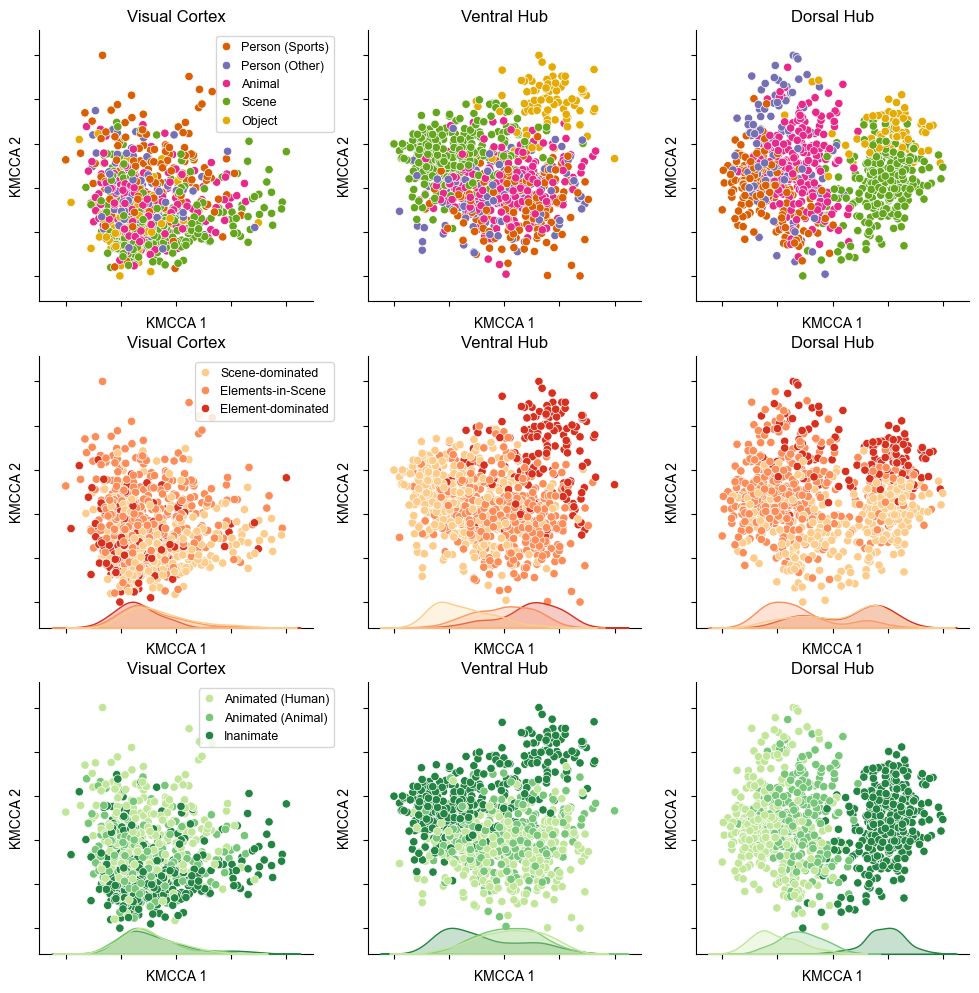

In [5]:
rois = ["visual_cortex", "ventral_hub", "dorsal_hub"]

fig, axes = scatter_plots(
    df=df,
    hue=hue,
    rois=rois,
    palettes=palettes,
    hue_orders=hue_order,
    histograms=True,
    axis_names=["KMCCA 1", "KMCCA 2"],
    margin=0.12,
    s=12 / 3,
)

# Reduce horizontal space between color legend and text labels in legend
for i in range(len(hue)):
    axes[i, 0].legend(**legend_config)

fig.savefig(output_folder / "01_cluster_kmcca_scatter.pdf", bbox_inches="tight", transparent=True)

## 4 – KMCCA per **individual ROI**  

Motivation – ensure within‑hub homogeneity and flag any ROI that deviates from hub‑level structure.  
Looping over `cluster_rois`, we reproduce the 3‑colour scatter grid for every constituent ROI.

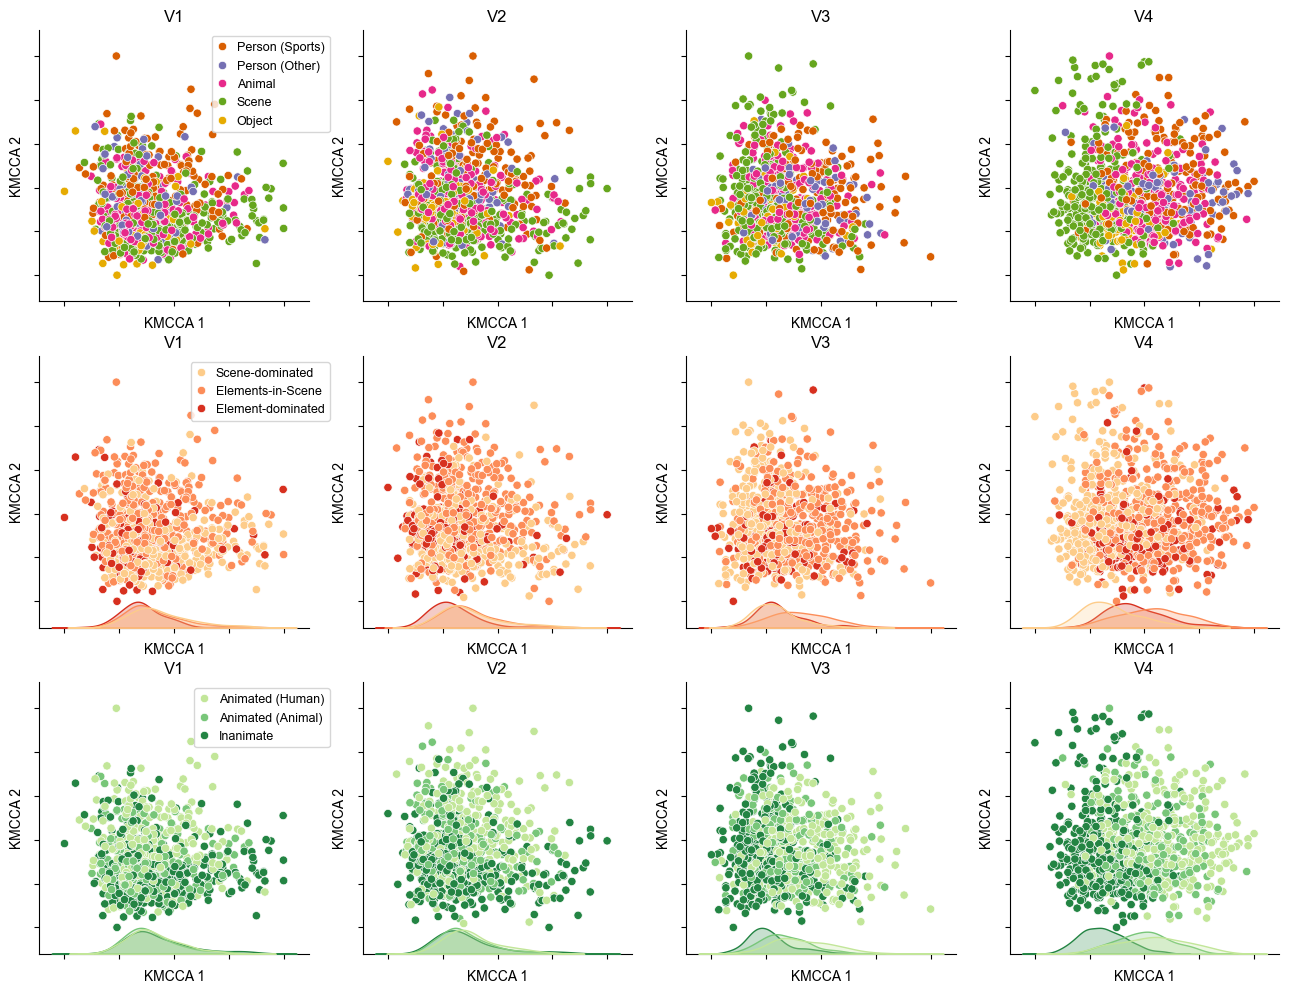

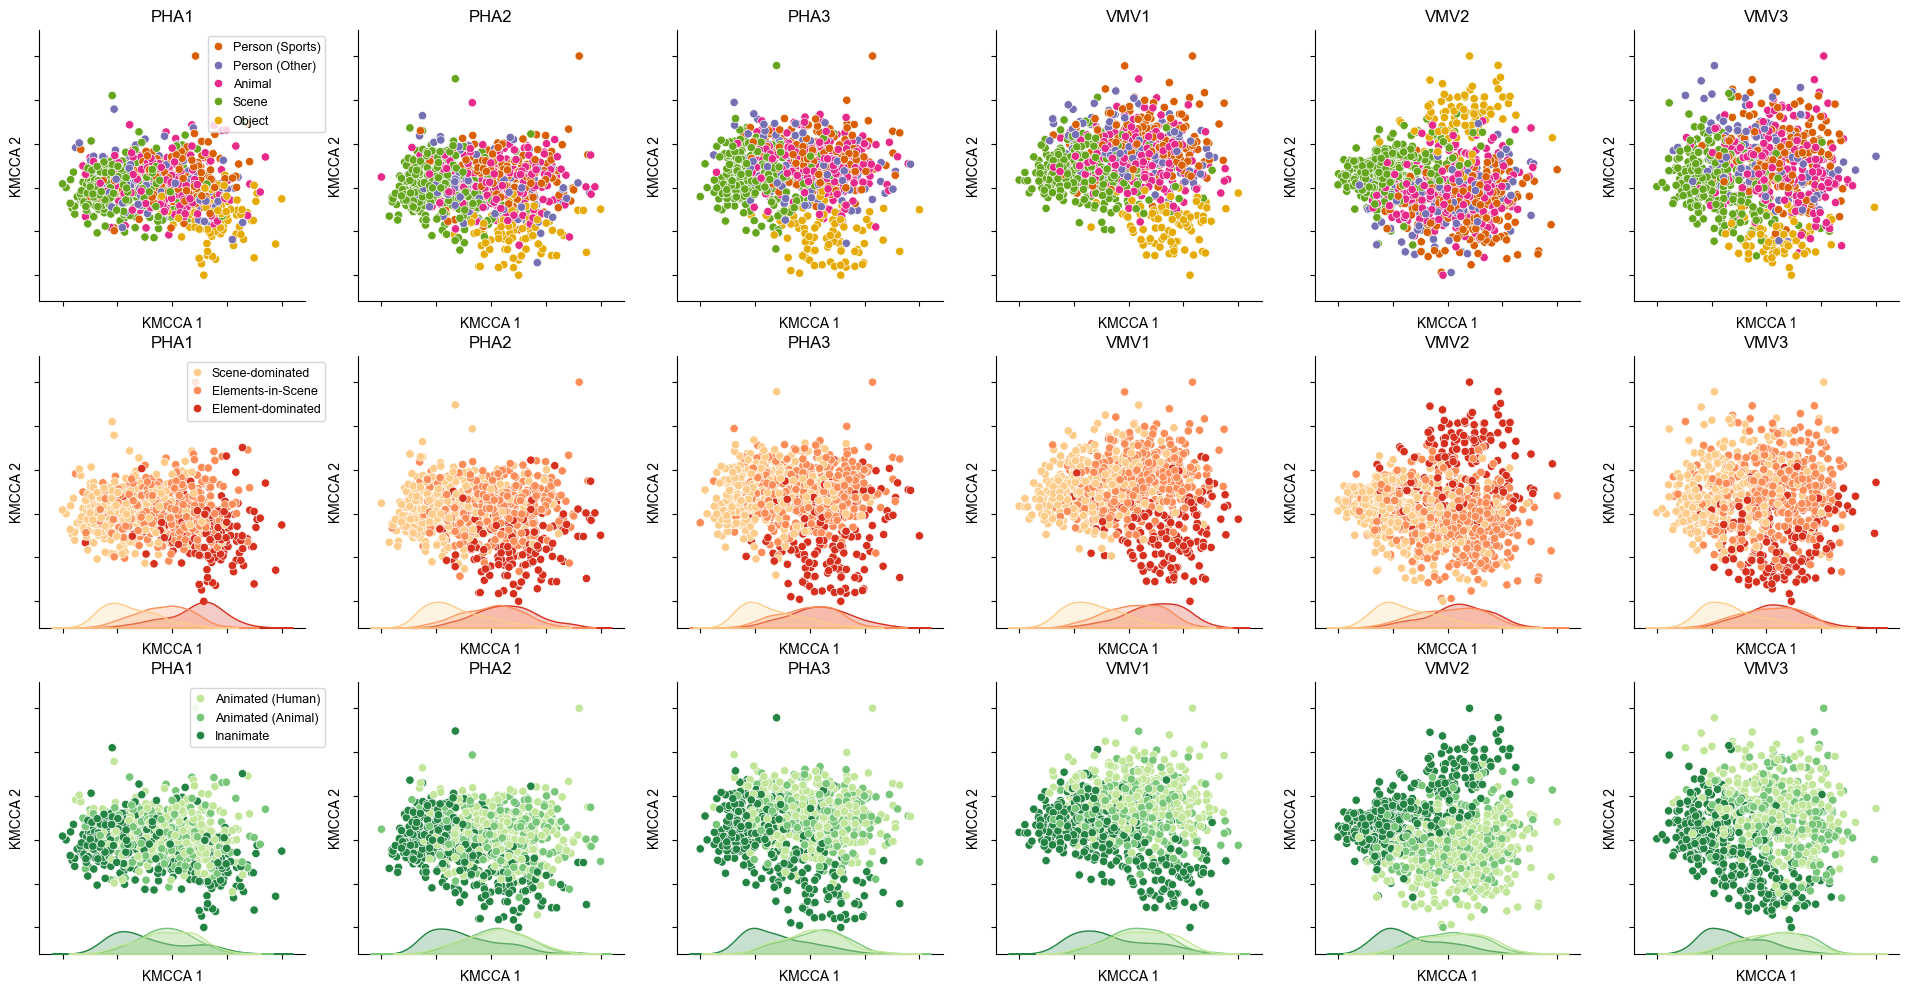

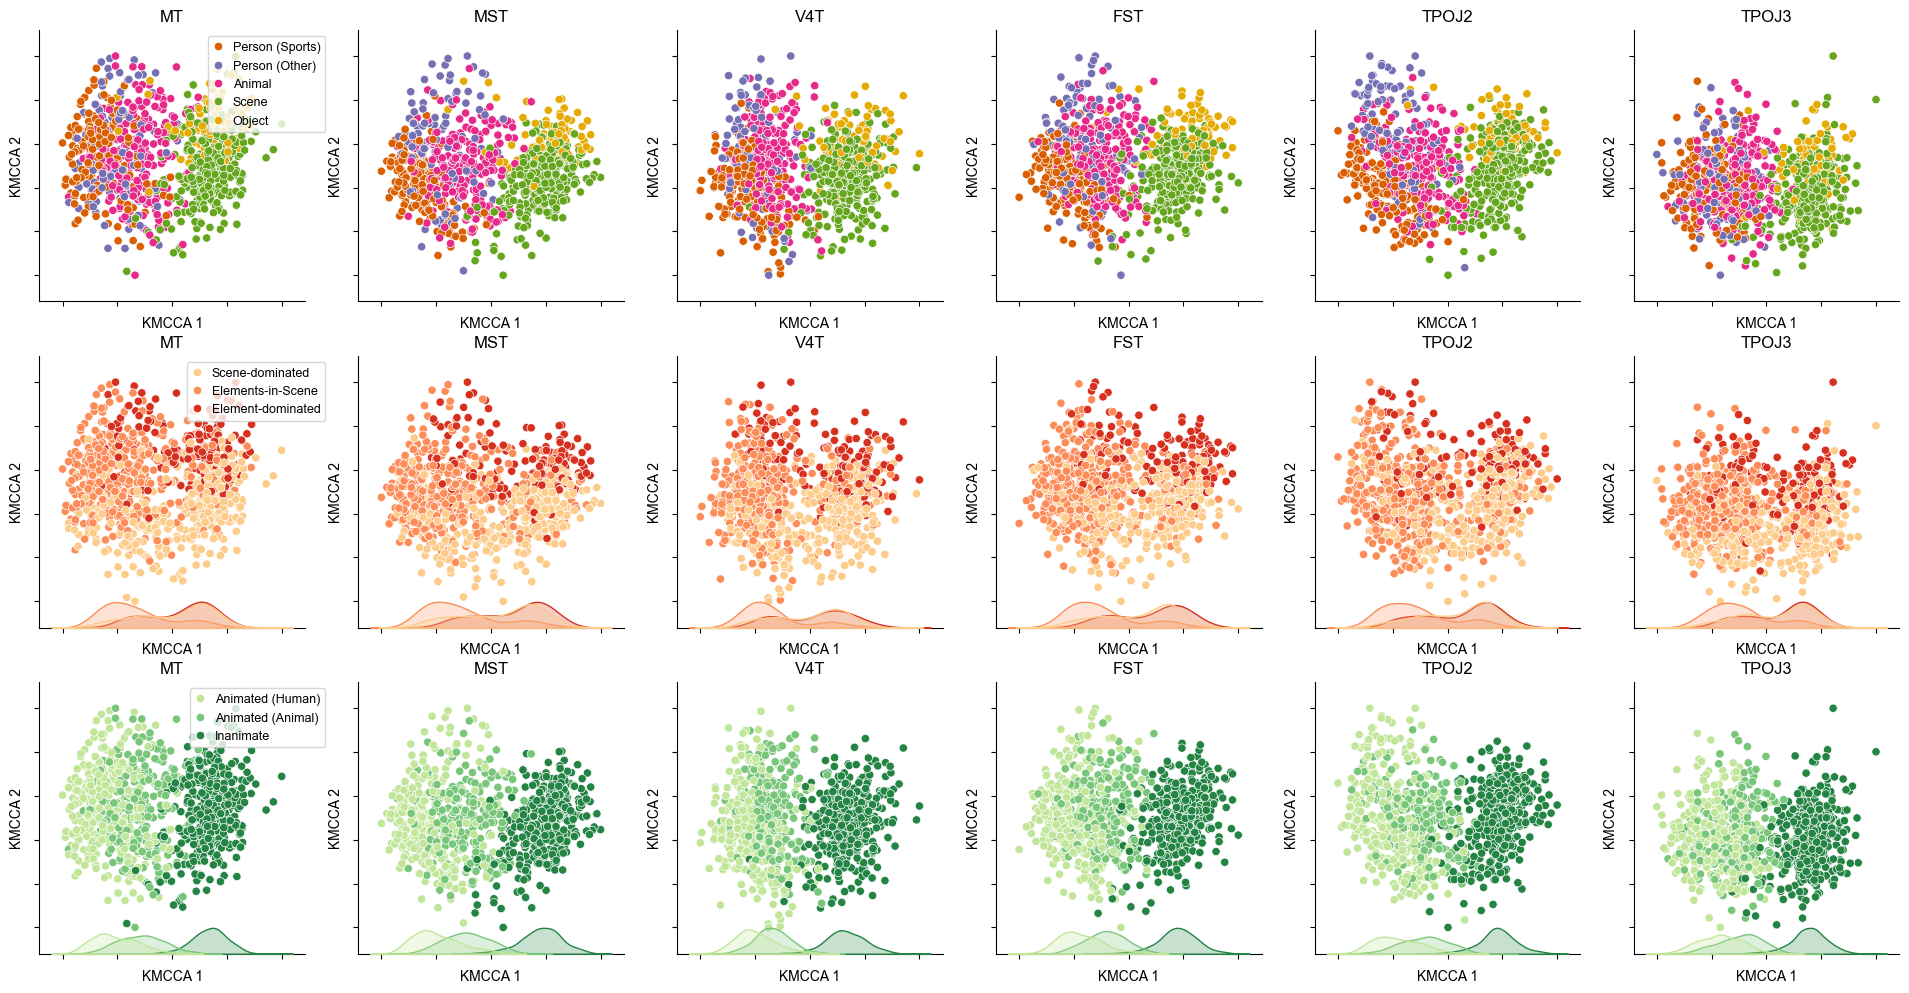

In [6]:
for name, rois in cluster_rois.items():
    fig, axes = scatter_plots(
        df=df,
        hue=hue,
        rois=rois,
        palettes=palettes,
        hue_orders=hue_order,
        histograms=True,
        axis_names=["KMCCA 1", "KMCCA 2"],
        margin=0.12,
        s=12 / 3,
    )
    for ax in axes.flat:
        title = ax.get_title()
        ax.set_title(title.upper())    
    
    for i in range(len(hue)):
        axes[i, 0].legend(**legend_config)
    
    filename = f"02_cluster_kmcca_scatter_{name.lower().replace(' ', '_')}.pdf"
    fig.savefig(output_folder / filename, bbox_inches="tight", transparent=True)

## 5 – Load Controlled RSA tables  

`unify_controlled_rsa_data()` stacks four modalities  
(Intersubject, Withinsubject, Vision‑model, Language‑model) × many control regressors  
into one long DataFrame (`df_controlled`) from the precomputed tables of alignment.

Rows correspond to self‑alignment (roi = roi); connectivity rows are dropped here (when `roi` ≠ `roi`).

Relevant columns: `roi` (the glasser atlas roi id), `subject` (the subject id), `modality` (the modality of the alignment: within-subject, inter-subject, vision model-brain, language model-brain), `control` the controlled variables (the regressors used to control the alignment), and `similarity` the similarity value of the alignment based on partial rsa.


In [7]:
df_controled = unify_controlled_rsa_data(
    filename_hcp=filename_hcp,
    filename_subject_controlled=filename_intersubject_controled_separated,
    filename_model_controlled=filename_model_controled_separated,
    models_info_filename=models_info_filename,
    cluster_rois=cluster_rois,
    group_cluster=False,
    group_subjects=False,
)
df_controled

roi  subject              control       modality  similarity name  \
0         1        1              biology  Withinsubject    0.376763   V1   
1         1        1       biology_binary  Withinsubject    0.377290   V1   
2         1        1     dorsal_hub_cca_1  Withinsubject    0.377285   V1   
3         1        1   dorsal_hub_cca_1-3  Withinsubject    0.377191   V1   
4         1        1     dorsal_hub_cca_2  Withinsubject    0.377032   V1   
...     ...      ...                  ...            ...         ...  ...   
149755  360        4  visual_cortex_cca_2         Vision    0.020963  p24   
149756  360        5  visual_cortex_cca_2         Vision    0.022936  p24   
149757  360        6  visual_cortex_cca_2         Vision    0.008457  p24   
149758  360        7  visual_cortex_cca_2         Vision    0.009748  p24   
149759  360        8  visual_cortex_cca_2         Vision    0.002147  p24   

              cluster      mne_name                       area  area_id  \
0       Visual Cortex   L_V1_ROI-lh             Primary Visual        0   
1       Visual Cortex   L_V1_ROI-lh             Primary Visual        0   
2       Visual Cortex   L_V1_ROI-lh             Primary Visual        0   
3       Visual Cortex   L_V1_ROI-lh             Primary Visual        0   
4       Visual Cortex   L_V1_ROI-lh             Primary Visual        0   
...               ...           ...                        ...      ...   
149755          Other  R_p24_ROI-rh  Anterior Cingulate & mPFC       18   
149756          Other  R_p24_ROI-rh  Anterior Cingulate & mPFC       18   
149757          Other  R_p24_ROI-rh  Anterior Cingulate & mPFC       18   
149758          Other  R_p24_ROI-rh  Anterior Cingulate & mPFC       18   
149759          Other  R_p24_ROI-rh  Anterior Cingulate & mPFC       18   

        rep_shift  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
149755         -1  
149756         -1  
149757         -1  
149758         -1  
149759         -1  

[149760 rows x 11 columns]

### 5a – Brain‐surface sanity check  
We render flat‑map RSA (> 18 k parcels) **after** partialling each control variable to verify that:  
1. Partialling the *relevant* KMCCA dimension reduces hub‑specific RSA.  
2. Partialling **irrelevant** dimensions leaves the map largely unchanged.  

Progress bar tracks ~ `len(modalities) × len(controls) × 2 hemis × 3 views = 312` renders.


In [8]:
df_controled = unify_controlled_rsa_data(
    filename_hcp=filename_hcp,
    filename_subject_controlled=filename_intersubject_controled_separated,
    filename_model_controlled=filename_model_controled_separated,
    models_info_filename=models_info_filename,
    cluster_rois=cluster_rois,
    group_cluster=False,
    group_subjects=True,
)

vmax_modalities = {
    'Intersubject': 0.2,
    'Withinsubject': 0.25,
    'Vision': 0.15,
    'Language': 0.15,
}
views = ["lateral", "medial", "ventral"]
hemispheres = ["lh", "rh"]

control_variables = df_controled.control.unique()
modalities = df_controled.modality.unique()

brain_folder = output_folder / "03_controled_surfaces"
brain_folder.mkdir(parents=True, exist_ok=True)
view = "lateral"  # Default view for the brain images
total = len(modalities) * len(control_variables) * len(hemispheres) * len(views)
pbar = tqdm(total=total, desc="Generating brain images")
for modality in modalities:
    vmax = vmax_modalities.get(modality, 0.25)
    for control in control_variables:
        df_subset = df_controled.query(f"modality == @modality and control == @control")
        for hemisphere in hemispheres:
            filename = brain_folder / f"03_controled_brain_{modality.lower()}_{control.lower()}_{hemisphere}_{view}.png"
            if filename.exists():
                pbar.update(len(views))
                continue
            brain = plot_faverage_parcelation(
                df_subset,
                value_column='similarity',
                normalize=(-vmax, vmax),
                cmap="RdBu_r",
                default_color='lightgrey',
                default_value=None,
                size = (800, 600),
                hemisphere=hemisphere,
            )
            for view in views:
                brain.show_view(view)
                filename = f"03_controled_brain_{modality.lower()}_{control.lower()}_{hemisphere}_{view}.png"
                brain.save_image(brain_folder / filename, mode='rgba')
                pbar.update(1)
            
            brain.close()
pbar.close()

Generating brain images:   0%|          | 0/312 [00:00<?, ?it/s]

## 6 – Hub‑level impact of each control  

For each modality we compute, per hub, the RSA drop after partialling the *dominant* KMCCA component (we take the mean across rois in each hub).
Bar + strip plots display raw RSA vs. partial RSA; significance brackets come from paired t‑tests with bonferroni correction.

<details>

* **LOTC** loses the most alignment when controlling for its own KMCCA‑1 → confirms that this component captures LOTC‑specific variance.  
* Early Visual shows minimal change → main kmcca explain few information in comparison with lotc.
* All modalities show similar patterns → support that the KMCCA subspace capture the same across all modalities.

</details>


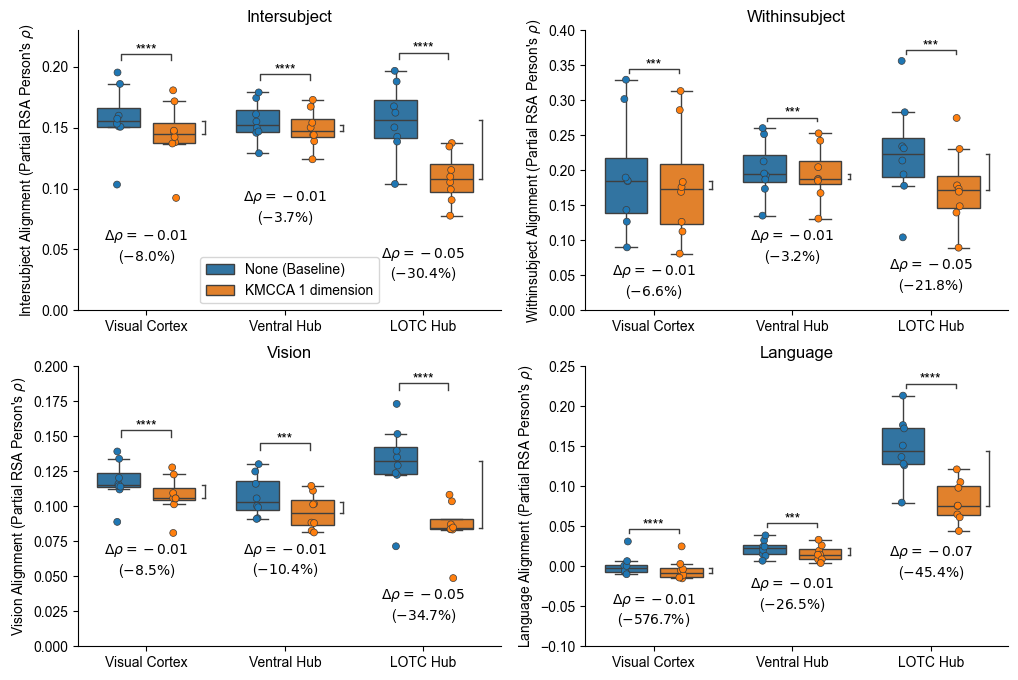

In [9]:
df_controled_clusters = unify_controlled_rsa_data(
    filename_hcp=filename_hcp,
    filename_subject_controlled=filename_intersubject_controled_joined,
    filename_model_controlled=filename_model_controled_joined,
    models_info_filename=models_info_filename,
    cluster_rois=cluster_rois,
    group_cluster=True,
    group_subjects=False,
)

fig, axes = plt.subplots(2, 2, figsize=(6*2, 4*2))
modality = "Intersubject"

modalities = ["Intersubject", "Withinsubject", "Vision", "Language"]
for i, (ax, modality) in enumerate(zip(axes.flat, modalities)):
    df_plot_controled_clusters, comparisons, _ = obtain_modality_main_controls(df_controled_clusters, modality)
    h3 = 0.02 if modality == "Vision" else 0.04
    plot_clusters_controled(df_plot_controled_clusters, comparisons, modality=modality, ax=ax, h3=h3)
    ax.set_title(modality)
    
    if i != 0:
        ax.get_legend().remove()
# Adjust lims

axes[0, 0].set_ylim(0, 0.23)
axes[0, 1].set_ylim(0, 0.4)
axes[1, 0].set_ylim(0, 0.2)
axes[1, 1].set_ylim(-0.1, 0.25)

output_filename = output_folder / "04_controled_clusters_main_kmcca.pdf"
fig.savefig(output_filename, bbox_inches="tight", transparent=True)

## 7 – Composite panel for main figure

Creates a 3 × 4 mosaic:  
A‑C = hub projections (one colour factor each)  
D   = hub‑level controlled RSA summary  
Remaining slots reserved for brain map insert (added in Illustrator).

Layout tuned for the print version (0.8 scaling, constrained layout).


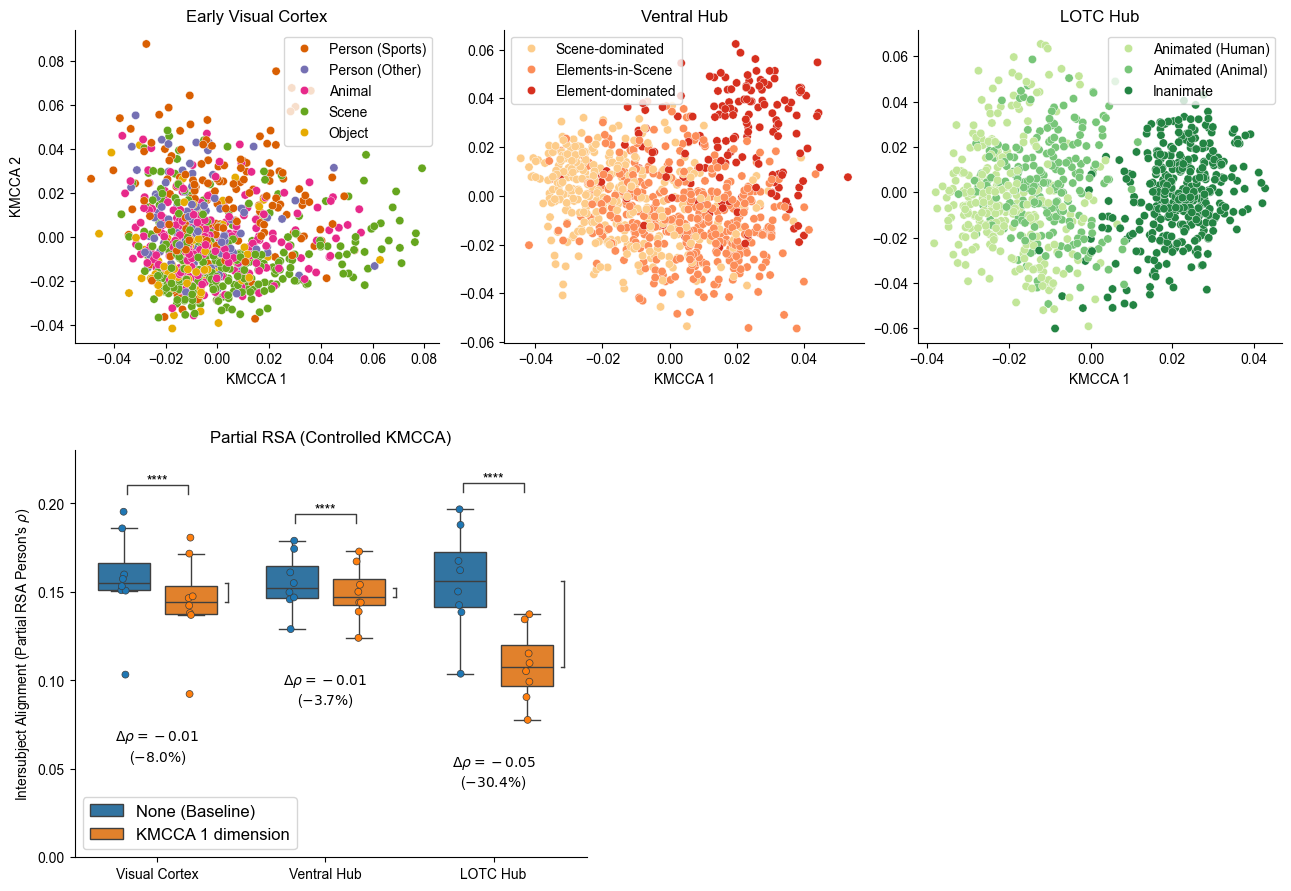

In [10]:
fig, axes = plt.subplot_mosaic(
    """
    AAABBBCCC
    DDDD.....
    """,
    figsize=(16*0.8, 11*0.8),
    sharey=False,
    sharex=False,
    gridspec_kw={"hspace": 0.1},
    layout="constrained",
    height_ratios=[1, 1.3],
    
)

# Plot the most relevant ROIs in the first row (A, B, C)
subpanels = [
    {'subpanel': 'A',
     'roi': 'visual_cortex',
     'hue': 'category2',
     'title': "Early Visual Cortex"},
    {'subpanel': 'B',
     'roi': 'ventral_hub',
     'hue': 'scene_dominated2',
     'title': "Ventral Hub"},
    {'subpanel': 'C',
     'roi': 'dorsal_hub',
     'hue': 'biology',
     'title': "LOTC Hub"},
]

for subpanel_data in subpanels:
    roi = subpanel_data['roi']
    df_plot = df.query("roi == @roi").copy()
    ax = axes[subpanel_data['subpanel']]
    hue_name = subpanel_data['hue']
    sns.scatterplot(data=df_plot,
                    x='cca_1', 
                    y='cca_2', 
                    hue=hue_name, 
                    lw=0.3,
                    ax=ax, 
                    palette=palettes[hue_name], 
                    hue_order=hue_order[hue_name])
    title = subpanel_data['title']
    ax.set_title(title, fontsize="large")
    sns.despine(ax=ax)
    ax.set_xlabel("KMCCA 1")
    ax.set_ylabel("")
    ax.legend(title="")

axes['A'].set_ylabel("KMCCA 2")
ax4 = axes['D']

modality = "Intersubject"
df_plot_controled_clusters, comparisons, _ = obtain_modality_main_controls(df_controled_clusters, modality)
    
plot_clusters_controled(df_plot_controled_clusters, comparisons, modality=modality, ax=ax4, h3=0.03)
ax4.set_ylim(0, 0.23)
# Make legend larger
ax4.legend(title="", loc="best", ncol=1, fontsize=12)
filename = output_folder / "05_panel_KMCCA_and_clusters_controlled.pdf"
fig.savefig(filename, bbox_inches="tight", transparent=True)

## 8 – Pairwise hub comparison of RSA drop  

Stat test: for every pair of hubs, paired t‑test on the RSA reduction (`partial − raw`).  
Bonferroni‑corrected p‑values + APA stars reported in `df_differences`.

<details>

LOTC reduction > Ventral > EVC, reinforcing hierarchical emergence of semantic control.

</details>


In [11]:
modality = "Intersubject" # "Withinsubject"

_, _, df_comparisons_controls = obtain_modality_main_controls(df_controled_clusters, modality)

df_comparisons_controls["diff"] = df_comparisons_controls["partial_rsa"] - df_comparisons_controls['rsa']
clusters = df_comparisons_controls["cluster"].unique()
differences = []
for cluster1 in clusters:
    for cluster2 in clusters:
        if cluster1 < cluster2:
            df_subset = df_comparisons_controls.query(f"cluster == @cluster1 or cluster == @cluster2")
            subset_cluster1_diff = df_subset.query(f"cluster == @cluster1")["diff"]
            subset_cluster2_diff = df_subset.query(f"cluster == @cluster2")["diff"]
            t_stat, p_value = ttest_rel(subset_cluster1_diff, subset_cluster2_diff)
            differences.append({
                "cluster1": cluster1,
                "cluster2": cluster2,
                "cluster1_mean_diff": subset_cluster1_diff.mean(),
                "cluster2_mean_diff": subset_cluster2_diff.mean(),
                "t_stat": t_stat,
                "p_value": p_value
            })

df_differences = pd.DataFrame(differences)
df_differences["p_value_corrected"] = multipletests(df_differences["p_value"], method="bonferroni")[1]
df_differences["apa_star"] = df_differences["p_value_corrected"].apply(apa_star)
df_differences

cluster1       cluster2  cluster1_mean_diff  cluster2_mean_diff  \
0     LOTC Hub    Ventral Hub           -0.047491           -0.005712   
1     LOTC Hub  Visual Cortex           -0.047491           -0.012578   
2  Ventral Hub  Visual Cortex           -0.005712           -0.012578   

      t_stat   p_value  p_value_corrected apa_star  
0 -12.210694  0.000006           0.000017     ****  
1 -10.786134  0.000013           0.000039     ****  
2  11.659584  0.000008           0.000023     ****

## 9 – Top‑/Tail‑word loadings  

Load KMCCA word‑weight table (`kmcca_top_words_dimension.parquet`), plot top 20 and bottom 20 tokens per hub.


* **EVC** extremes are objects that share low‑level texture/colour words (airplane, boats). Same that are in the extremes of the projections (see atlas).
* **Ventral** extremes include scene labels vs. object nouns that display movement (kitchen, bathroom vs. bird, plate)
* **LOTC** extremes contrast human‑centric verbs/nouns with inanimate terms, echoing animate selectivity.



In [12]:
df_words = pd.read_parquet(filename_top_words)
df_words

token     score   hub
0      airplane  0.027529   EVC
1         boats  0.022813   EVC
2        parked  0.021448   EVC
3        runway  0.020892   EVC
4         plane  0.017956   EVC
...         ...       ...   ...
33268    piping  0.000000  LOTC
33269     pipes  0.000000  LOTC
33270  pipeline  0.000000  LOTC
33271      pipe  0.000000  LOTC
33272         !  0.000000  LOTC

[33273 rows x 3 columns]

Plot the top (positive and negative) words for each hub, to see the main words that explain the organization of the hubs.

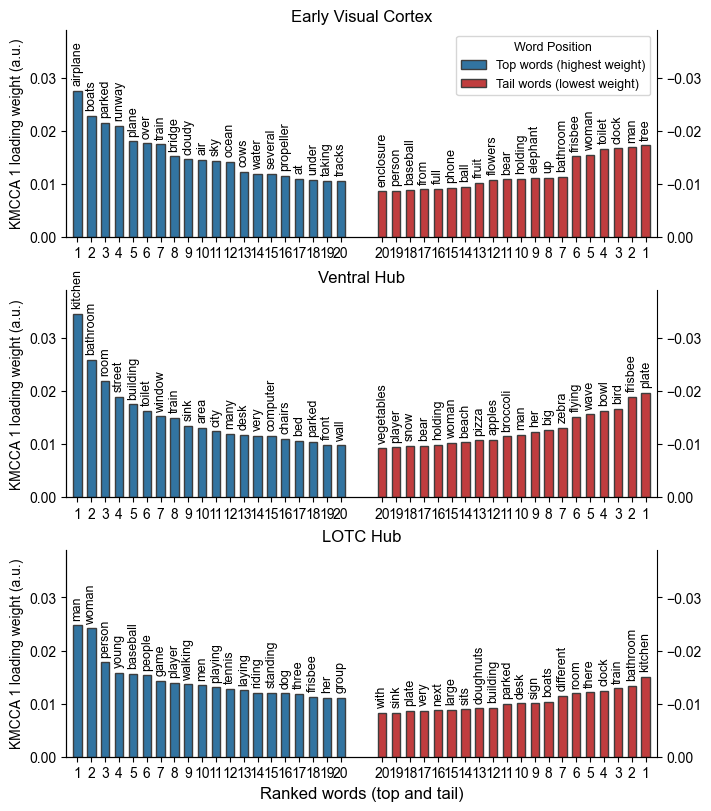

In [13]:
def words_plot(df_words, axes, top=20, space=3):
    df_words = df_words.copy()
    df_words["abs_score"] = df_words["score"].abs()
    for panel, roi in [("J", "EVC"), ("K", "Ventral"), ("L", "LOTC")]:
        ax = axes[panel]
        df_words_top = df_words.query("hub==@roi").sort_values("score", ascending=False).head(top)
        df_words_top = df_words_top.reset_index(drop=True).reset_index().rename(columns={"index": "rank"})
        df_words_top["rank"] = df_words_top["rank"] + 1
        df_words_top["position"] = "top"
        df_words_bottom = df_words.query("hub==@roi").sort_values("score", ascending=False).tail(top)
        df_words_bottom = df_words_bottom.reset_index(drop=True).reset_index().rename(columns={"index": "rank"})
        df_words_bottom["rank"] = df_words_bottom["rank"] + space + top
        df_words_bottom["position"] = "tail"
        
        df_empty = pd.DataFrame({"rank": range(top+1, top+space)})
        df_empty["position"] = "space"
        df_empty["token"] = ""

        df_words_top = pd.concat([df_words_top, df_empty, df_words_bottom], ignore_index=True)
        df_words_top


        sns.barplot(data=df_words_top, x="rank", y="abs_score", hue="position", ax=ax,  edgecolor=(0.24, 0.24, 0.24), dodge=False, errorbar=None, width=0.6, capsize=0.1, lw=1, legend=roi=='EVC', palette={"top": "C0", "tail": "C3", "space": "C1"}, hue_order=["top", "space", "tail"])
        ax.set_ylabel("KMCCA 1 loading weight (a.u.)", fontsize=10)
        sns.despine(ax=ax)

        # Legend remove title and remove space category
        if roi == "EVC":
            handles, labels = ax.get_legend_handles_labels()
            handles = [handles[0], handles[2]]  # Keep only "top" and "tail"
            labels = ["Top words (highest weight)", "Tail words (lowest weight)"]
            ax.legend(handles, labels, title="Word Position", title_fontsize=9, loc="upper right", fontsize=9)

        for i, row in df_words_top.iterrows():
            ax.text(row["rank"] -1, row["abs_score"] + 0.001, row["token"], ha="center", va="bottom", fontsize=9, rotation=90)

        ax.set_xlim(-0.8, top + space + top - 1 -0.2)
        #ax.set_xticks(np.arange(0, top + space + top, 1))
        ax.set_xticks(np.concat([np.arange(0, top), np.arange(top + space-1, top + space + top - 1)]))

        order = 1 + np.arange(0, top)
        ax.set_xticklabels(np.concat([order, order[::-1]]), fontsize=10)
        ax2 = ax.twinx()
        ax.set_ylim(0, 0.039)
        ax2.set_ylim(-0.039, 0)
        ax2.invert_yaxis()
        ax.set_yticks([0, 0.01, 0.02, 0.03])
        ax2.set_yticks([0, -0.01, -0.02, -0.03])
        sns.despine(ax=ax2, left=False, right=False)
        ax.set_xlabel("")
        ax.set_ylabel("KMCCA 1 loading weight (a.u.)", fontsize=10)

    axes["J"].set_title("Early Visual Cortex", fontsize="large")
    axes["K"].set_title("Ventral Hub", fontsize="large")
    axes["L"].set_title("LOTC Hub", fontsize="large")
    axes["L"].set_xlabel("Ranked words (top and tail)", fontsize=12)

output_filename = output_folder / "06_kmcca_top_words.pdf"
fig, axes = plt.subplot_mosaic(
    """
    J
    K
    L
    """,
    figsize=(7, 8),
    sharey=False,
    sharex=False,
    layout="constrained",
)


words_plot(df_words, axes)
fig.savefig(output_filename, bbox_inches="tight", transparent=True)

## 10 – Supplementary mega‑panel  

Assembles ROI‑level scatters (A–F), word bars (J–L) and alternative controlled‑RSA boxplots (G–I) where controls are **semantic categories** rather than KMCCA axes.  This lets us see that categorical variables drive similar alignment reductions as the learnt KMCCA dimensions.


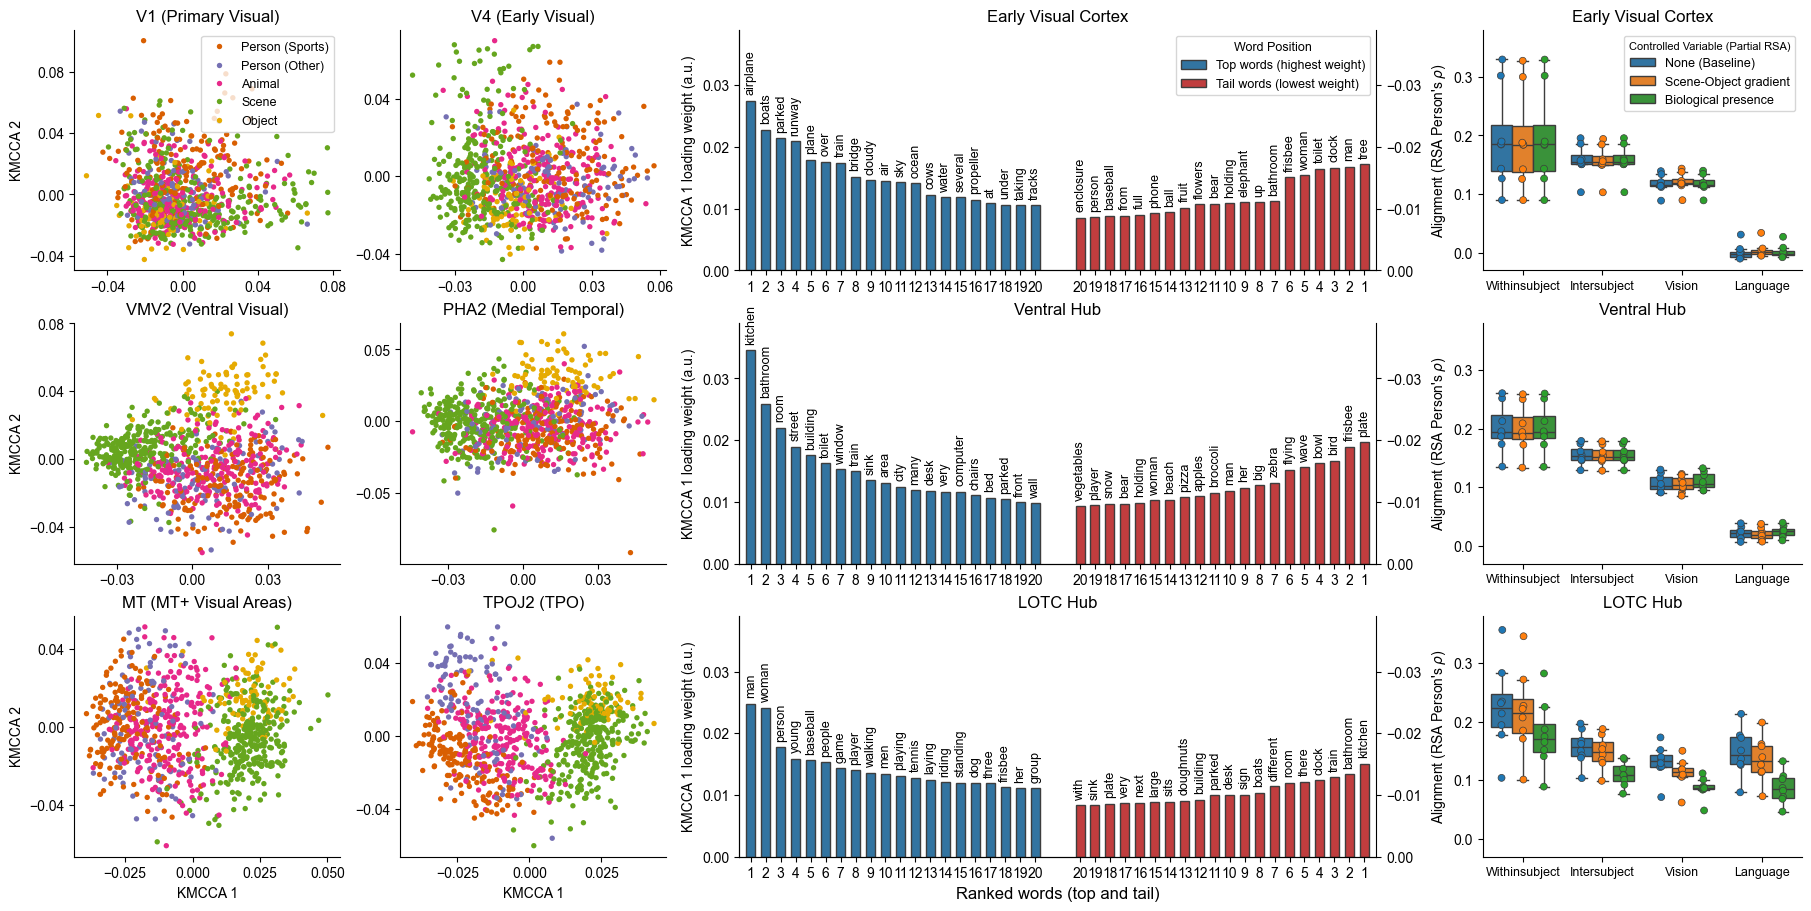

In [14]:

output_filename = output_folder / "07_supplementary_pannel_kmcca.pdf"

mosaic_pannel = [
    ["A", "B", "J", "G"],
    ["C", "D", "K", "H"],
    ["E", "F", "L", "I"],
]

fig, axes = plt.subplot_mosaic(
    mosaic_pannel,
    figsize=(18, 9),
    width_ratios=[0.5, 0.5, 1.2, 0.6],
    height_ratios=[1, 1, 1],
    sharex=False,
    sharey=False,
    layout="constrained",
)

# Plots A-F: Scatter
# PLOT KMCCA projections for each ROI (First two columns)
rois_pannels = {
    "A": "V1",
    "B": "V4",
    "C": "VMV2",
    "D": "PHA2",
    "E": "MT",
    "F": "TPOJ2",
}
hcp = pd.read_csv(filename_hcp).query("roi <= 180").set_index("name")
var = "category2"
palette = palettes[var]
category_orders = hue_order[var]
for panel, roi in rois_pannels.items():
    ax = axes[panel]
    df_plot_roi = df.query("roi == @roi").copy()
    if roi == "PHA2":
        df_plot_roi["cca_2"] *= -1

    sns.scatterplot(
        data=df_plot_roi,
        x="cca_1",
        y="cca_2",
        hue=var,
        ax=ax,
        palette=palette,
        hue_order=category_orders,
        linewidth=0,
        s=15,
    )
    if roi != "V1":
        ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    area = hcp.loc[roi, "area"].replace(" (V2-4)", "")
    ax.set_title(f"{roi} ({area})", fontsize="large")
    sns.despine(ax=ax)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))

axes["A"].legend(title="", loc="upper right", ncol=1, fontsize=9)
axes["A"].set_ylabel("KMCCA 2")
axes["C"].set_ylabel("KMCCA 2")
axes["E"].set_ylabel("KMCCA 2")
axes["E"].set_xlabel("KMCCA 1")
axes["F"].set_xlabel("KMCCA 1")


# PLOT J-L: Top words for each hub
df_words = pd.read_parquet(filename_top_words)
df_words["abs_score"] = df_words["score"].abs()
words_plot(df_words, axes)



df_controled_clusters = unify_controlled_rsa_data(
    filename_hcp=filename_hcp,
    filename_subject_controlled=filename_intersubject_controled_joined,
    filename_model_controlled=filename_model_controled_joined,
    models_info_filename=models_info_filename,
    cluster_rois=cluster_rois,
    group_cluster=True,
    group_subjects=False,
)
row_order = ["Intersubject", "Vision", "Language"]
cluster_order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
controls = ["visual_cortex_cca_1", "ventral_hub_cca_1", "dorsal_hub_cca_1"]
control = ['uncontrolled', 'biology_binary', 'scene']
control_names = {
"uncontrolled": "None (Baseline)",
"scene": "Scene-Object gradient",
"biology_binary": "Biological presence",
}
axes_last = (axes["G"], axes["H"], axes["I"])
order = ['Withinsubject', 'Intersubject', 'Vision', 'Language']
for i,hub in enumerate(['Visual Cortex', 'Ventral Hub', 'LOTC Hub']):

    df_controled_clusters_plot = df_controled_clusters.query("cluster==@hub and control in @control").copy()
    
    df_controled_clusters_plot.control = df_controled_clusters_plot.control.astype(str)
    df_controled_clusters_plot.control = df_controled_clusters_plot.control.replace(control_names)

    hue_order_2 = list(control_names.values())
    ax = axes_last[i]
    sns.boxplot(data=df_controled_clusters_plot, x='modality', y='similarity', hue='control', ax=ax, hue_order=hue_order_2, order=order, legend=i==0, showfliers=False)
    # Add an strip plot
    sns.stripplot(data=df_controled_clusters_plot, x='modality', y='similarity', hue='control', ax=ax, hue_order=hue_order_2, order=order, alpha=1, marker="o", size=5, edgecolor=(0.24, 0.24, 0.24), linewidth=0.5, jitter=0.03, legend=False, dodge=True)
    if i == 0:
        ax.legend(title="Controlled Variable (Partial RSA)", title_fontsize=8, loc="upper right", fontsize=9)
    sns.despine(ax=ax)
    ax.set_ylim(-0.03, 0.38)
    name_hub = hub.replace("Dorsal", "LOTC").replace("Visual", "Early Visual")
    ax.set_title(f"{name_hub}", fontsize="large")
    ax.set_xlabel("")
    ax.set_ylabel(r"Alignment (RSA Person's $\rho$)", fontsize=10)
    # Make xticks smaller
    ax.set_xticks(np.arange(len(order)))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)    


fig.savefig(output_filename, bbox_inches="tight", transparent=True)


## 11 – Miniature scatter (pipeline tease)  

Generates a 2 cm thumbnail showing LOTC projection coloured by `category2`.  
Used in the methods flow‑chart to visually cue the KMCCA step.


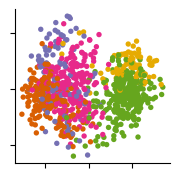

In [15]:

fig, ax = plt.subplots(figsize=(2, 2))
sns.scatterplot(
    data=df.query("roi == 'dorsal_hub'"),
    x="cca_1",
    y="cca_2",
    hue="category2",
    palette=palettes["category2"],
    hue_order=hue_order["category2"],
    linewidth=0,
    s=15,
    ax=ax,
    legend=False
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine(ax=ax)
fig.savefig(output_folder / "09_dorsal_hub_kmcca_scatter_miniature.pdf", bbox_inches="tight", transparent=True)